# Implement GLM and Contrast Function
A generalized linear model is used to find where brain activity changes given different tasks
The contrast function compares the brain activity between target and general task.

We are interested in the following contrast:
- Differentiate brain region activity between target and general task during audio condition
- Differentiate brain region activity between target and general task during visual condition
- Differentiate brain region activity between audio and visual condition after contrast is applied to both conditions

In [1]:
# import dependencies
from nilearn.glm.first_level import FirstLevelModel
import numpy as np
import nibabel as nib
import nilearn.masking as masking
from nilearn.image import mean_img
import os
import glob
import pandas as pd
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import compute_regressor


In [2]:
# Categorize stimuli into target and general task
def categorize_stimuli(data_path):
    """ 
    Categorize stimuli based on the filename patterns in the events.tsv file
    For visual data: 'inh' = general task, 'sel' = target task
    events_data: pandas dataframe pulled from the events.tsv file
    data_path: path to the visual folder 
    """

    pattern = os.path.join(data_path, 'sub-*/func/*events.tsv')
    event_files = glob.glob(pattern, recursive=True)
    if not event_files:
        raise ValueError(f"No events files found in {pattern}")
    print("event_files: ", event_files)

    # initialize empty list to store all events
    all_events = []

    for file_path in event_files:
        # load events file as a dataframe
        events = pd.read_csv(file_path, sep='\t')
        # categorize stimuli
        if 'Inh' in file_path:
            events['condition'] = 'general'
        elif 'Sel' in file_path:
            events['condition'] = 'target'      
        
        events['subject'] = os.path.basename(file_path).split('_')[0] # get the id of the subject
        all_events.append(events) # append the events to the list
    
    # concatenate all events into a single dataframe
    categorized_events = pd.concat(all_events, ignore_index=True)

    # print summary
    print("\nData Summary")
    print("Total number of events:", len(categorized_events))

    print("Events by condition:")
    print(categorized_events['condition'].value_counts())
    inhibition_tasks = categorized_events[categorized_events['condition'] == 'general']
    print("Inhibition tasks: ", inhibition_tasks)
    selection_tasks = categorized_events[categorized_events['condition'] == 'target']
    print("Selective Attention tasks: ", selection_tasks)

    print("\nEvents by subject:")
    print(categorized_events['subject'].value_counts())
    
    return categorized_events

In [3]:
# Implement glm base model
def fit_glm(fmri_img, categorized_events, tr):
    """ 
    Fit a glm to the fmri data and the categorized events data
    """

    mask = masking.compute_epi_mask(
        fmri_img,
        lower_cutoff = 0.1,
        upper_cutoff = 0.9,
        connected = False,
        opening = False
    )

    model = FirstLevelModel(
        t_r=tr,
        mask_img = mask,
        standardize = True,
        minimize_memory = True,
    )
    
    glm = model.fit(fmri_img, events = categorized_events)
    
    return glm

In [4]:
# Implement contrast function

def contrast_glm_conditions(glm):
    """ 
    Apply a contrast to the glm results
    """
    # init contrast vector
    contrast_vector = np.zeros(6)

    contrast_vector[1] = 1 # target column
    contrast_vector[2] = -1 # general column

    print("Contrast vector: ", contrast_vector)

    contrast = glm.compute_contrast(contrast_vector)

    return contrast

def contrast_glm_stimuli(glm, categorized_events, data_path): 
    """ 
    Apply a contrast to the glm results for different stimulus events
    """

    # contrast vector
    contrast_vector = np.zeros(6)

    # contrast values
    contrast_vector[1] = 1
    contrast_vector[2] = -1

    print("Full Contrast vector: ", contrast_vector)

    contrast = glm.compute_contrast(contrast_vector)
    return contrast

In [5]:
def create_drift_regressor(frame_times, order):
    """ 
    Create polynomial drift regressors
    """
    # normalize time to [-1, 1] interval
    t = 2 * (frame_times - frame_times.mean()) / (frame_times.max() - frame_times.min())
    # return polynomial specified order
    return t ** order

# function to get design matrix
def create_design_matrix(events_data, glm):
    """ 
    Create a design matrix for the glm results
    """
    # Create base design matrix with HRF
    frame_times = np.arange(0, 156 * tr, tr)  # 156 time points
    
    # Define conditions
    conditions = {
        'target': events_data[events_data['trial_type'] == 'target'],
        'general': events_data[events_data['trial_type'] == 'general'],
        'response': events_data[events_data['trial_type'] == 'response']
    }
    
    # Create design matrix with additional complexity
    design_matrix = pd.DataFrame(index=frame_times)
    
    # Add task regressors
    for condition, events in conditions.items():
        design_matrix[condition] = compute_regressor(
            events['onset'],
            events['duration'],
            events['modulation'] if 'modulation' in events else np.ones(len(events)),
            frame_times
        )
    
    # Add temporal derivatives
    for condition in conditions.keys():
        design_matrix[f'{condition}_derivative'] = np.gradient(design_matrix[condition])
    
    # Add motion parameters
    motion_params = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
    for param in motion_params:
        if param in events_data.columns:
            design_matrix[f'motion_{param}'] = events_data[param].values
    
    # Add drift regressors
    drift_order = 4
    for i in range(drift_order):
        design_matrix[f'drift_{i+1}'] = create_drift_regressor(frame_times, i+1)
    
    # Add constant term
    design_matrix['constant'] = 1
    
    return design_matrix


In [6]:
# Define parameters 
data_path = "../data/" # path to data folder
fmri_data = "../results/visual/cleaned_data_visual.nii.gz" #TODO: need to add audio data
fmri_img = nib.load(fmri_data)
tr = 1.5 # test with visual data

event_files:  ['../data/sub-213/func/sub-213_task-Conj1Inh_acq-a_events.tsv', '../data/sub-213/func/sub-213_task-Feat19Sel_acq-b_events.tsv', '../data/sub-213/func/sub-213_task-Conj9Inh_acq-a_events.tsv', '../data/sub-213/func/sub-213_task-Conj19Sel_acq-a_events.tsv', '../data/sub-213/func/sub-213_task-Feat1Inh_acq-b_events.tsv', '../data/sub-213/func/sub-213_task-Feat9Inh_acq-b_events.tsv', '../data/sub-214/func/sub-214_task-Conj19Sel_acq-a_events.tsv', '../data/sub-214/func/sub-214_task-Conj9Inh_acq-a_events.tsv', '../data/sub-214/func/sub-214_task-Conj1Inh_acq-a_events.tsv', '../data/sub-214/func/sub-214_task-Feat9Inh_acq-a_events.tsv', '../data/sub-222/func/sub-222_task-Feat9Inh_acq-a_events.tsv', '../data/sub-222/func/sub-222_task-Conj1Inh_acq-a_events.tsv', '../data/sub-222/func/sub-222_task-Conj19Sel_acq-a_events.tsv', '../data/sub-222/func/sub-222_task-Conj9Inh_acq-a_events.tsv', '../data/sub-222/func/sub-222_task-Feat1Inh_acq-a_events.tsv', '../data/sub-222/func/sub-222_task-F

/Users/jaslavie/Desktop/attention/venv/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:70: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn(
/Users/jaslavie/Desktop/attention/venv/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:88: UserWarning: Unexpected column 'NR' in events data. It will be ignored.
  warnings.warn(
/Users/jaslavie/Desktop/attention/venv/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:88: UserWarning: Unexpected column 'block_type_intended' in events data. It will be ignored.
  warnings.warn(
/Users/jaslavie/Desktop/attention/venv/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:88: UserWarning: Unexpected column 'errors_total' in events data. It will be ignored.
  warnings.warn(
/Users/jaslavie/Desktop/attention/venv/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:88: UserWarning: Un

columns:  ['dummy', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'constant']
Full Contrast vector:  [ 0.  1. -1.  0.  0.  0.]
Contrast vector:  [ 0.  1. -1.  0.  0.  0.]


<Axes: label='conditions', ylabel='scan number'>

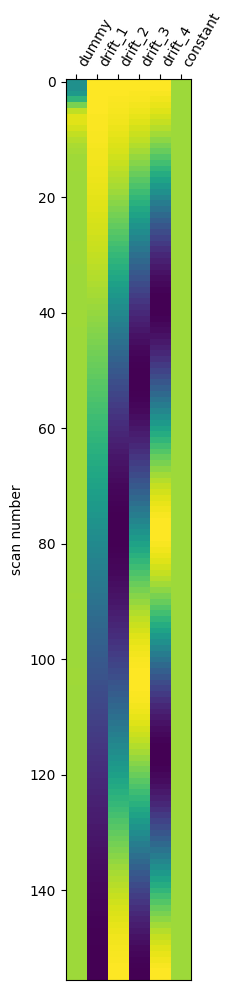

In [7]:
# function to run contrast and glm
def run_glm_contrast(fmri_img, data_path, tr):
    """ 
    Run the glm on the fmri data and apply contrast
    """ 
    categorized_events = categorize_stimuli(data_path)
    print("categorized events: ", categorized_events)
    
    # Get GLM object 
    glm = fit_glm(fmri_img, categorized_events, tr)
    
    # Get design matrix
    design_matrix = glm.design_matrices_[0]
    design_matrix_columns = design_matrix.columns.tolist()
    print("columns: ", design_matrix_columns)
    design_matrix.columns = ['dummy', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'constant' ]
    
    # Compute contrasts
    contrast_stimuli = contrast_glm_stimuli(glm, categorized_events, data_path)
    contrast_conditions = contrast_glm_conditions(glm)
    
    return glm, design_matrix, contrast_stimuli, contrast_conditions

# Run GLM and get results
glm, design_matrix, contrast_stimuli, contrast_conditions = run_glm_contrast(fmri_img, data_path, tr)

# Plot design matrix (not the contrast)
plot_design_matrix(design_matrix)